In [7]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import math as m
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from scipy import sparse
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from tqdm import tqdm

import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\amitk\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [8]:
import tensorflow as tf
tf.test.gpu_device_name()

''

# Importing Dataset

In [9]:
data = pd.read_csv('C:\\Users\\amitk\\OneDrive\\Desktop\\preprocessed_data.csv')

In [10]:
data.head()

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03
2,ca,mrs,grades_prek_2,10,1,literacy_language,literacy,having class 24 students comes diverse learner...,329.00
3,ga,mrs,grades_prek_2,2,1,appliedlearning,earlydevelopment,i recently read article giving students choice...,481.04
4,wa,mrs,grades_3_5,2,1,literacy_language,literacy,my students crave challenge eat obstacles brea...,17.74


In [11]:
negative = []
positive = []
neutral = []
compound = []

def update_sentiments(values):
    negative.append(values["neg"])    
    positive.append(values["pos"])
    neutral.append(values["neu"])
    compound.append(values["compound"])

In [12]:
from tqdm import tqdm
for essay in tqdm(data["essay"]):
    update_sentiments(sid.polarity_scores(essay))

100%|█████████████████████████████████████████████████████████████████████████| 109248/109248 [03:11<00:00, 571.49it/s]


In [13]:
data["neg"] = negative
data["pos"] = positive
data["neu"] = neutral        # adding new features to dataset based on  Sentiment Intensity Analyzer
data["compound"] = compound

In [14]:
data.head()

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price,neg,pos,neu,compound
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05,0.013,0.205,0.783,0.9867
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03,0.072,0.248,0.680,0.9897
2,ca,mrs,grades_prek_2,10,1,literacy_language,literacy,having class 24 students comes diverse learner...,329.00,0.017,0.262,0.721,0.9860
3,ga,mrs,grades_prek_2,2,1,appliedlearning,earlydevelopment,i recently read article giving students choice...,481.04,0.030,0.187,0.783,0.9524
4,wa,mrs,grades_3_5,2,1,literacy_language,literacy,my students crave challenge eat obstacles brea...,17.74,0.029,0.288,0.683,0.9873


# Splitting Data Into Train And Cross Validation(or test): Stratified Sampling

In [15]:
y = data['project_is_approved'].values
X = data.drop(['project_is_approved'], axis=1)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y,random_state=42) 

In [17]:
print("Total data points in Train Dataset =",len(y_train))
print("Total data points in Test Dataset =",len(y_test))

Total data points in Train Dataset = 73196
Total data points in Test Dataset = 36052


In [18]:
tfidfvectorizer = TfidfVectorizer(min_df=10,max_features=5000)
text_tfidf = tfidfvectorizer.fit(X_train['essay'].values) #fitting

X_train_essay_tfidf =tfidfvectorizer.transform(X_train['essay'].values) 
X_test_essay_tfidf =tfidfvectorizer.transform(X_test['essay'].values)   # transform

print("After vectorizations")
print(X_train_essay_tfidf.shape, y_train.shape)
print(X_test_essay_tfidf.shape, y_test.shape)
print("="*40)

After vectorizations
(73196, 5000) (73196,)
(36052, 5000) (36052,)


# TFIDF W2V

In [19]:
import pickle
with open('C:\\Users\\amitk\\OneDrive\\Desktop\\glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [20]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['essay'].values)
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [21]:
#TFIDF W2V for train dataset
train_tfidf_w2v_essays = [] # the tfidf-w2v for each essay is stored in this list
for sentence in tqdm(X_train['essay']): 
    vector = np.zeros(300) 
    tf_idf_weight =0; 
    for word in sentence.split():
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] 
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) 
            vector += (vec * tf_idf) 
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    train_tfidf_w2v_essays.append(vector)
X_train_essay_tfidf_w2v= sparse.csr_matrix(train_tfidf_w2v_essays)
print("After vectorizations")
print(X_train_essay_tfidf_w2v.shape, y_train.shape)
print("="*40)

100%|███████████████████████████████████████████████████████████████████████████| 73196/73196 [02:25<00:00, 502.14it/s]


After vectorizations
(73196, 300) (73196,)


In [22]:
#TFIDF W2V for test dataset
test_tfidf_w2v_essays = [] # the tfidf-w2v for each essay is stored in this list
for sentence in tqdm(X_test['essay']): 
    vector = np.zeros(300) 
    tf_idf_weight =0;
    for word in sentence.split():
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] 
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) 
            vector += (vec * tf_idf)
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    test_tfidf_w2v_essays.append(vector)
X_test_essay_tfidf_w2v= sparse.csr_matrix(test_tfidf_w2v_essays)
print("After vectorizations")
print(X_test_essay_tfidf_w2v.shape, y_test.shape)
print("="*40)

100%|███████████████████████████████████████████████████████████████████████████| 36052/36052 [01:11<00:00, 502.14it/s]


After vectorizations
(36052, 300) (36052,)


In [23]:
def fit(feature):
    X_train['class_label']=y_train # adding 'project_is_approved' column to x_train
    count = X_train[ feature ].value_counts() # getting value counts(denominator) of each category
    feature_dictionary = dict()
    for i, denominator in count.items():
        vector = []
        for j in range(2):
            compare =X_train.loc[ ( X_train['class_label'] == j ) & (X_train[feature] == i ) ]
            vector.append( len( compare)  / denominator   )
        feature_dictionary[i] = vector    # adding probability of each class label for a pariticular category of feature
    return feature_dictionary  
def transform(feature, df ):
    feature_dictionary = fit(feature)
    count = X_train[feature].value_counts()
    f=[]
    for cat in df[feature]:
        if cat in dict( count ).keys():# transform test data with trainning probabilities
            f.append( feature_dictionary[cat] )
        else:
            f.append([0.5, 0.05])
    return f

In [24]:
X_train_state_rc =np.array(transform('school_state',X_train))
X_test_state_rc =np.array(transform('school_state',X_test)) 
print("After vectorizations")
print(X_train_state_rc.shape, y_train.shape)
print(X_test_state_rc.shape, y_test.shape)
print("="*40)

After vectorizations
(73196, 2) (73196,)
(36052, 2) (36052,)


In [25]:
X_train_teacher_rc =np.array(transform('teacher_prefix',X_train))
X_test_teacher_rc = np.array(transform('teacher_prefix',X_test))
print("After vectorizations")
print(X_train_teacher_rc.shape, y_train.shape)
print(X_test_teacher_rc.shape, y_test.shape)
print("="*40)

After vectorizations
(73196, 2) (73196,)
(36052, 2) (36052,)


In [26]:
X_train_grade_rc = np.array(transform('project_grade_category',X_train))
X_test_grade_rc = np.array(transform('project_grade_category',X_test))

print("After vectorizations")
print(X_train_grade_rc.shape, y_train.shape)
print(X_test_grade_rc.shape, y_test.shape)
print("="*40)

After vectorizations
(73196, 2) (73196,)
(36052, 2) (36052,)


In [27]:
X_train_category_rc =np.array(transform('clean_categories',X_train))
X_test_category_rc = np.array(transform('clean_categories',X_test))

print("After vectorizations")
print(X_train_category_rc.shape, y_train.shape)
print(X_test_category_rc.shape, y_test.shape)
print("="*40)

After vectorizations
(73196, 2) (73196,)
(36052, 2) (36052,)


In [28]:
X_train_subcategory_rc = np.array(transform('clean_subcategories',X_train))
X_test_subcategory_rc = np.array(transform('clean_subcategories',X_test))
print("After vectorizations")
print(X_train_subcategory_rc.shape, y_train.shape)
print(X_test_subcategory_rc.shape, y_test.shape)
print("="*40)

After vectorizations
(73196, 2) (73196,)
(36052, 2) (36052,)


In [29]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
#normalizer.fit(X_train['price'].values.reshape(1,-1)) #fitting

X_train_price_norm = normalizer.transform(X_train['price'].values.reshape(1,-1))  #transform
X_test_price_norm = normalizer.transform(X_test['price'].values.reshape(1,-1))

X_train_price_norm =X_train_price_norm.reshape(-1,1)
X_test_price_norm=X_test_price_norm.reshape(-1,1)

print("After vectorizations")
print(X_train_price_norm.shape, y_train.shape)
print(X_test_price_norm.shape, y_test.shape)
print("="*40)

After vectorizations
(73196, 1) (73196,)
(36052, 1) (36052,)


In [30]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
#normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1)) #fitting
X_train_submission_norm = normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))  #transform
X_test_submission_norm = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))

X_train_submission_norm =X_train_submission_norm .reshape(-1,1)
X_test_submission_norm=X_test_submission_norm.reshape(-1,1)

print("After vectorizations")
print(X_train_submission_norm.shape, y_train.shape)
print(X_test_submission_norm.shape, y_test.shape)
print("="*40)

After vectorizations
(73196, 1) (73196,)
(36052, 1) (36052,)


In [31]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
#normalizer.fit(X_train['neg'].values.reshape(1,-1)) #fitting

X_train_neg_norm = normalizer.transform(X_train['neg'].values.reshape(1,-1))  #transform
X_test_neg_norm = normalizer.transform(X_test['neg'].values.reshape(1,-1))

X_train_neg_norm =X_train_neg_norm .reshape(-1,1)
X_test_neg_norm=X_test_neg_norm.reshape(-1,1)

print("After vectorizations")
print(X_train_neg_norm.shape, y_train.shape)
print(X_test_neg_norm.shape, y_test.shape)
print("="*40)

After vectorizations
(73196, 1) (73196,)
(36052, 1) (36052,)


In [32]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
#normalizer.fit(X_train['pos'].values.reshape(1,-1)) #fitting

X_train_pos_norm = normalizer.transform(X_train['pos'].values.reshape(1,-1))  #transform
X_test_pos_norm = normalizer.transform(X_test['pos'].values.reshape(1,-1))

X_train_pos_norm =X_train_pos_norm .reshape(-1,1)
X_test_pos_norm=X_test_neg_norm.reshape(-1,1)

print("After vectorizations")
print(X_train_pos_norm.shape, y_train.shape)
print(X_test_pos_norm.shape, y_test.shape)
print("="*40)

After vectorizations
(73196, 1) (73196,)
(36052, 1) (36052,)


In [33]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
#normalizer.fit(X_train['neu'].values.reshape(1,-1)) #fitting
X_train_neu_norm = normalizer.transform(X_train['neu'].values.reshape(1,-1))
X_test_neu_norm = normalizer.transform(X_test['neu'].values.reshape(1,-1))

X_train_neu_norm =X_train_neu_norm .reshape(-1,1)
X_test_neu_norm=X_test_neu_norm.reshape(-1,1)

print("After vectorizations")
print(X_train_neu_norm.shape, y_train.shape)
print(X_test_neu_norm.shape, y_test.shape)
print("="*40)

After vectorizations
(73196, 1) (73196,)
(36052, 1) (36052,)


In [34]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
#normalizer.fit(X_train['compound'].values.reshape(1,-1)) #fitting

X_train_compound_norm = normalizer.transform(X_train['compound'].values.reshape(1,-1))  #transform
X_test_compound_norm = normalizer.transform(X_test['compound'].values.reshape(1,-1))

X_train_compound_norm =X_train_compound_norm .reshape(-1,1)
X_test_compound_norm=X_test_neu_norm.reshape(-1,1)

print("After vectorizations")
print(X_train_compound_norm.shape, y_train.shape)
print(X_test_compound_norm.shape, y_test.shape)
print("="*40)

After vectorizations
(73196, 1) (73196,)
(36052, 1) (36052,)


In [35]:
from scipy.sparse import hstack
X_tr_set_one = hstack((X_train_essay_tfidf, X_train_state_rc, X_train_teacher_rc, X_train_grade_rc, X_train_price_norm,X_train_category_rc,X_train_subcategory_rc,X_train_submission_norm,X_train_neg_norm ,X_train_pos_norm,X_train_neu_norm,X_train_compound_norm)).tocsr()
X_te_set_one = hstack((X_test_essay_tfidf, X_test_state_rc, X_test_teacher_rc, X_test_grade_rc, X_test_price_norm,X_test_category_rc,X_test_subcategory_rc,X_test_submission_norm,X_test_neg_norm,X_test_pos_norm,X_test_neu_norm,X_test_compound_norm)).tocsr()


In [36]:
print("SHAPE OF TRAIN AND TEST AFTER STACKING")
print(X_tr_set_one.shape)
print(X_te_set_one.shape)


SHAPE OF TRAIN AND TEST AFTER STACKING
(73196, 5016)
(36052, 5016)


In [37]:
from scipy.sparse import hstack
X_tr_set_two = hstack((X_train_essay_tfidf_w2v, X_train_state_rc, X_train_teacher_rc, X_train_grade_rc, X_train_price_norm,X_train_category_rc,X_train_subcategory_rc,X_train_submission_norm)).tocsr()
X_te_set_two = hstack((X_test_essay_tfidf_w2v, X_test_state_rc, X_test_teacher_rc, X_test_grade_rc, X_test_price_norm,X_test_category_rc,X_test_subcategory_rc,X_test_submission_norm)).tocsr()


In [38]:
print("SHAPE OF TRAIN AND TEST AFTER STACKING")
print(X_tr_set_two.shape)
print(X_te_set_two.shape)

SHAPE OF TRAIN AND TEST AFTER STACKING
(73196, 312)
(36052, 312)


In [39]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
parameters = {"max_depth":[1,2,3,4],"n_estimators":[5,10,15,20] }
clf = GridSearchCV(GradientBoostingClassifier(), parameters, cv=5,  scoring='roc_auc',return_train_score=True,n_jobs=-1)
clf.fit(X_tr_set_one,y_train)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4],
                         'n_estimators': [5, 10, 15, 20]},
             return_train_score=True, scoring='roc_auc')

In [40]:
train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

In [41]:
print('Best score: ',clf.best_score_)
print('Best Hyper parameters: ',clf.best_params_)

Best score:  0.6849341618522009
Best Hyper parameters:  {'max_depth': 4, 'n_estimators': 20}


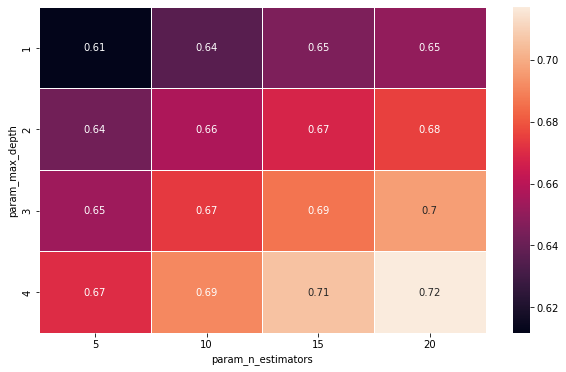

In [42]:
import pandas as pd
pvt = pd.pivot_table(pd.DataFrame(clf.cv_results_),
    values='mean_train_score', index='param_max_depth', columns='param_n_estimators') #https://stackoverflow.com/questions/48791709/how-to-plot-a-heat-map-on-pivot-table-after-grid-search
plt.figure(figsize=(10,6))
ax=sns.heatmap(pvt,annot=True,linewidths=.5)

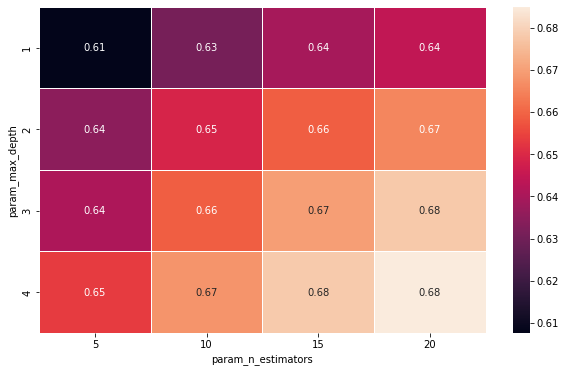

In [43]:
import pandas as pd
pvt = pd.pivot_table(pd.DataFrame(clf.cv_results_),
    values='mean_test_score', index='param_max_depth', columns='param_n_estimators') #https://stackoverflow.com/questions/48791709/how-to-plot-a-heat-map-on-pivot-table-after-grid-search
plt.figure(figsize=(10,6))
ax=sns.heatmap(pvt,annot=True,linewidths=.5)

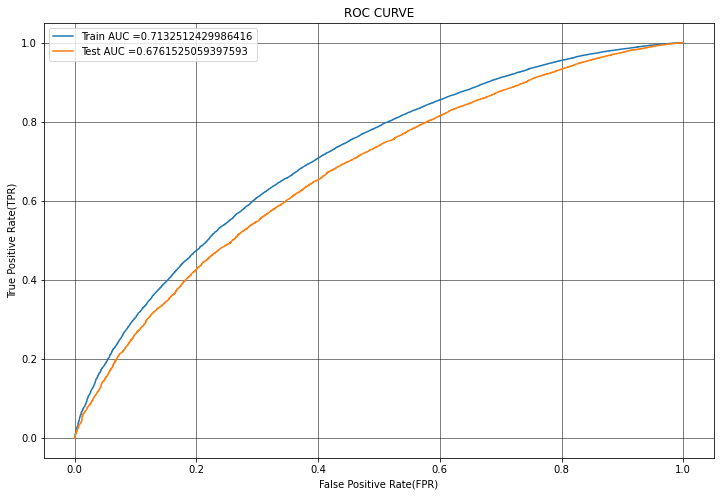

In [44]:
model_set1=GradientBoostingClassifier(max_depth = clf.best_params_["max_depth"], n_estimators= clf.best_params_["n_estimators"])
model_set1.fit(X_tr_set_one,y_train)
y_train_probs = clf.predict_proba(X_tr_set_one)[:,1] # converting train and test output into probability
y_test_probs= clf.predict_proba(X_te_set_one )[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_probs) # storing values of fpr and tpr
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_probs)

plt.figure(figsize=(12,8))
plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("ROC CURVE")
plt.grid(color='black',lw=0.5)

In [45]:
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

the maximum value of tpr*(1-fpr) 0.42971731634481375 for threshold 0.849
CONFUSION MATRIX OF TRAIN DATA


[[ 7328  3755]
 [21745 40368]]


Text(0.5, 1.0, 'Train Data Confusion Matrix')

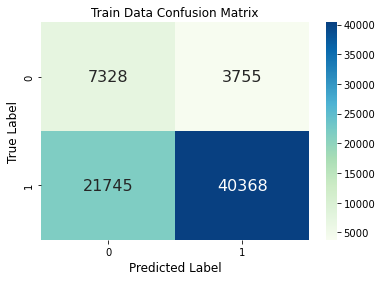

In [46]:
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
cm=metrics.confusion_matrix(y_train,predict_with_best_t(y_train_probs, best_t))  # https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix

print("CONFUSION MATRIX OF TRAIN DATA")
print("\n")
print(cm)
sns.heatmap(cm, annot=True, fmt='d',cmap='GnBu',annot_kws = {"size":16})
plt.ylabel('True Label',size=12)
plt.xlabel('Predicted Label',size=12)
plt.title('Train Data Confusion Matrix',size=12)

the maximum value of tpr*(1-fpr) 0.39430602468623105 for threshold 0.844
CONFUSION MATRIX OF TEST DATA


[[ 3355  2104]
 [10965 19628]]


Text(0.5, 1.0, 'Test Data Confusion Matrix')

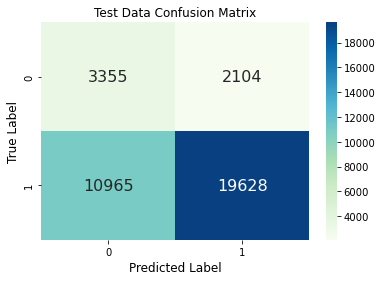

In [47]:
best_t = find_best_threshold(te_thresholds, test_fpr, test_tpr)
cm=metrics.confusion_matrix(y_test,predict_with_best_t(y_test_probs, best_t))
  
print("CONFUSION MATRIX OF TEST DATA")
print('\n')
print(cm)
sns.heatmap(cm, annot=True, fmt='d',cmap='GnBu',annot_kws = {"size":16})
plt.ylabel('True Label',size=12)
plt.xlabel('Predicted Label',size=12)
plt.title('Test Data Confusion Matrix',size=12)

In [48]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
parameters = {"max_depth":[1,2,3,4],"n_estimators":[5,10,15,20] }
clf = GridSearchCV(GradientBoostingClassifier(), parameters, cv=5,  scoring='roc_auc',return_train_score=True,n_jobs=-1)
clf.fit(X_tr_set_two,y_train)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4],
                         'n_estimators': [5, 10, 15, 20]},
             return_train_score=True, scoring='roc_auc')

In [49]:
train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

In [50]:
print('Best score: ',clf.best_score_)
print('Best Hyper parameters: ',clf.best_params_)

Best score:  0.690322767250764
Best Hyper parameters:  {'max_depth': 4, 'n_estimators': 20}


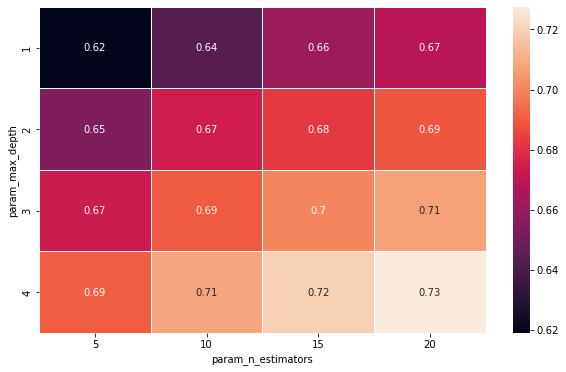

In [58]:
import pandas as pd
pvt = pd.pivot_table(pd.DataFrame(clf.cv_results_),
    values='mean_train_score', index='param_max_depth', columns='param_n_estimators') #https://stackoverflow.com/questions/48791709/how-to-plot-a-heat-map-on-pivot-table-after-grid-search
plt.figure(figsize=(10,6))
ax=sns.heatmap(pvt,annot=True,linewidths=.5)

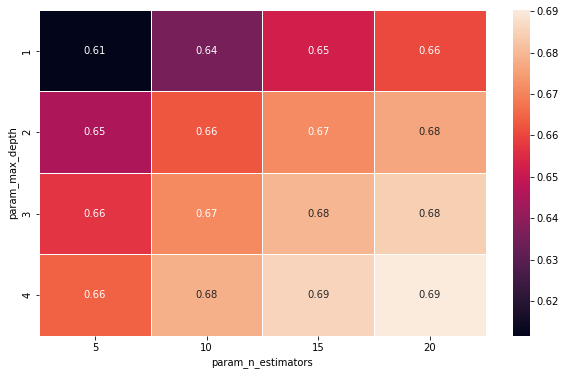

In [64]:
import pandas as pd
pvt = pd.pivot_table(pd.DataFrame(clf.cv_results_),
    values='mean_test_score', index='param_max_depth', columns='param_n_estimators') #https://stackoverflow.com/questions/48791709/how-to-plot-a-heat-map-on-pivot-table-after-grid-search
plt.figure(figsize=(10,6))
ax=sns.heatmap(pvt,annot=True,linewidths=.5)

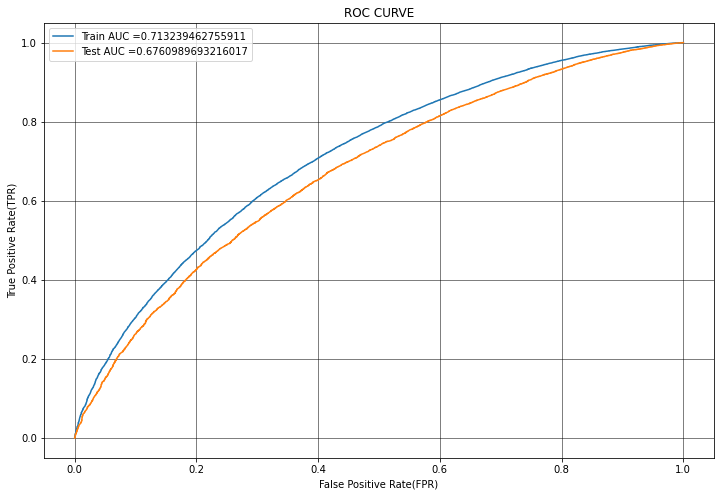

In [59]:
model_set2=GradientBoostingClassifier(max_depth = clf.best_params_["max_depth"], n_estimators= clf.best_params_["n_estimators"])
model_set2.fit(X_tr_set_one,y_train)
y_train_probs = model_set2.predict_proba(X_tr_set_one)[:,1] # converting train and test output into probability
y_test_probs= model_set2.predict_proba(X_te_set_one )[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_probs) # storing values of fpr and tpr
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_probs)

plt.figure(figsize=(12,8))
plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("ROC CURVE")
plt.grid(color='black',lw=0.5)

In [60]:
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

the maximum value of tpr*(1-fpr) 0.4297066713458952 for threshold 0.849
CONFUSION MATRIX OF TRAIN DATA


[[ 7328  3755]
 [21746 40367]]


Text(0.5, 1.0, 'Train Data Confusion Matrix')

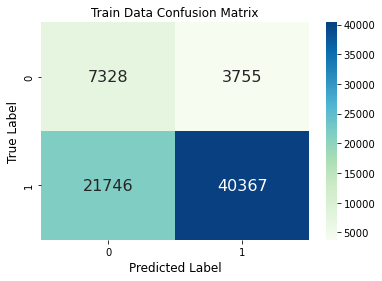

In [61]:

best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
cm=metrics.confusion_matrix(y_train,predict_with_best_t(y_train_probs, best_t))  # https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix

print("CONFUSION MATRIX OF TRAIN DATA")
print("\n")
print(cm)
sns.heatmap(cm, annot=True, fmt='d',cmap='GnBu',annot_kws = {"size":16})
plt.ylabel('True Label',size=12)
plt.xlabel('Predicted Label',size=12)
plt.title('Train Data Confusion Matrix',size=12)

the maximum value of tpr*(1-fpr) 0.3942256688629814 for threshold 0.844
CONFUSION MATRIX OF TEST DATA


[[ 3355  2104]
 [10969 19624]]


Text(0.5, 1.0, 'Test Data Confusion Matrix')

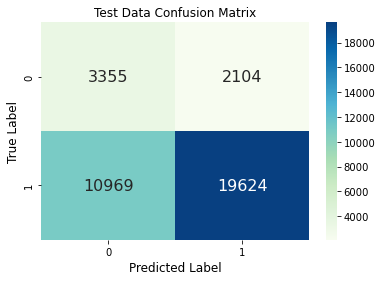

In [62]:
best_t = find_best_threshold(te_thresholds, test_fpr, test_tpr)
cm=metrics.confusion_matrix(y_test,predict_with_best_t(y_test_probs, best_t))
  
print("CONFUSION MATRIX OF TEST DATA")
print('\n')
print(cm)
sns.heatmap(cm, annot=True, fmt='d',cmap='GnBu',annot_kws = {"size":16})
plt.ylabel('True Label',size=12)
plt.xlabel('Predicted Label',size=12)
plt.title('Test Data Confusion Matrix',size=12)

In [63]:
from prettytable import PrettyTable
from prettytable import ALL as ALL
table=PrettyTable(hrules=ALL)
table.field_names = [ "Sl.N0","Vectorizer", "Model", "Hyper Parameter", "Test-AUC"] # # http://zetcode.com/python/prettytable/
table.add_row([1,"TFIDF", "GRADIENT BOOSTING CLASSIFIER", "max_depth =4 , n_estimators=20", 0.67515])
table.add_row([2,"TFIDF W2V", "GRADIENT BOOSTING CLASSIFIER"," max_depth =4 , n_estimators=20", 0.67517])
print(table)

+-------+------------+------------------------------+---------------------------------+----------+
| Sl.N0 | Vectorizer |            Model             |         Hyper Parameter         | Test-AUC |
+-------+------------+------------------------------+---------------------------------+----------+
|   1   |   TFIDF    | GRADIENT BOOSTING CLASSIFIER |  max_depth =4 , n_estimators=20 | 0.67515  |
+-------+------------+------------------------------+---------------------------------+----------+
|   2   | TFIDF W2V  | GRADIENT BOOSTING CLASSIFIER |  max_depth =4 , n_estimators=20 | 0.67517  |
+-------+------------+------------------------------+---------------------------------+----------+
